In [28]:
import ast
import base64
import io
import json
import operator
import os
import re
import sqlite3
import uuid
from datetime import datetime
from pprint import pprint
from typing import Annotated, Any, Dict, Literal, Optional, TypedDict

import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import seaborn as sns
from langchain.tools import ToolRuntime, tool
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolCall,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langsmith import Client
from pydantic import BaseModel, Field
from sqlalchemy import create_engine, text

dotenv.load_dotenv()
API_KEY = os.getenv("OPENROUTER_API_KEY")
BASE_URL = os.getenv("API_BASE_URL")
MODEL_NAME = "qwen/qwen3-coder-30b-a3b-instruct"  # os.getenv("MODEL_NAME")
LLM = ChatOpenAI(model=MODEL_NAME, base_url=BASE_URL, api_key=API_KEY)
# ls_client = Client()

# LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
# LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
# LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "database": "user_db",
    "user": "user",
    "password": "user",
}

### Agent state

In [29]:
class AgentState(TypedDict):
    user_input: str
    messages: list[Any]  # История сообщений LLM
    sql_query: str
    df_list: list[Dict[str, Any]]  # Результаты SQL
    chart_list: list[str]  # Пути к графикам
    should_continue: bool
    iteration: int
    max_iterations: int
    tool_calls: list[Dict[str, Any]]  # Для ToolNode

In [30]:
DB_PROMPT = """
СУБД: PostgreSQL 16
Тематика данных: пациенты, их диагнозы, рецепты и медикаменты в разрезе районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).
Особенности данных:

Все текстовые поля приведены к нижнему регистру.

Пол пациента: 'м' (мужчина), 'ж' (женщина).

В таблице явно представлены регионы: 'санкт-петербург', 'ленинградская область'.

Районы ЛО: ['колпино', 'ломоносов', 'сестрорецк', 'петродворец', 'павловск', 'пушкин', 'красное село', 'металлострой', 'зеленогорск', 'горелово'].

Районы СПб: ['пушкинский', 'выборгский', 'калининский', 'приморский', 'московский', 'кронштадтский', 'красносельский', 'кировский', 'адмиралтейский', 'фрунзенский', 'невский', 'красногвардейский', 'василеостровский', 'центральный', 'петроградский', 'курортный', 'колпинский', 'петродворцовый'].

Центральные районы СПб: ['адмиралтейский', 'василеостровский', 'центральный', 'петроградский'].

```sql
-- Пациенты
CREATE TABLE patients (
    id INTEGER PRIMARY KEY,
    дата_рождения DATE,
    пол VARCHAR(10),
    район_проживания VARCHAR(100),
    регион VARCHAR(100)
);

-- Диагнозы
CREATE TABLE diagnoses (
    код_мкб VARCHAR(20) PRIMARY KEY,
    название_диагноза TEXT,
    класс_заболевания TEXT
);

-- Медикаменты
CREATE TABLE medication (
    код_препарата INTEGER PRIMARY KEY,
    дозировка VARCHAR(100),
    торговое_название VARCHAR(100),
    стоимость FLOAT,
    мета_информация VARCHAR(200)
);

-- Рецепты
CREATE TABLE recipes (
    дата_рецепта DATE,
    код_диагноза VARCHAR(20),
    код_препарата INTEGER,
    id_пациента INTEGER,
    FOREIGN KEY (id_пациента) REFERENCES patients(id),
    FOREIGN KEY (код_диагноза) REFERENCES diagnoses(код_мкб),
    FOREIGN KEY (код_препарата) REFERENCES medication(код_препарата)
);
```
"""

In [39]:
def get_db_engine():
    url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    return create_engine(url)


class ExecuteSQLInput(BaseModel):
    query: str = Field(description="SQL query to execute")


@tool(args_schema=ExecuteSQLInput)
def execute_sql_tool(query: str) -> list[dict[str, Any]] | str:
    """Выполняет SQL запрос и возвращает результат как список словарей."""
    try:
        engine = get_db_engine()
        if "limit" not in query.lower():
            query = query.rstrip(";") + " LIMIT 25;"

        with engine.connect() as conn:
            df = pd.read_sql(text(query), conn)

        if df.empty:
            return "Query executed successfully but returned no results."

        return df.to_dict(orient="records")
    except Exception as e:
        return f"SQL Error: {str(e)}"


class PlotChartInput(BaseModel):
    df: list[dict] | str = Field(description="DataFrame data as list of dicts")
    chart_type: str = Field(description="Type of chart: histogram, barplot, lineplot, scatterplot")
    x: str = Field(description="Column name for x-axis")
    y: str = Field(description="Column name for y-axis")
    hue: Optional[str] = Field(default=None, description="Column name for hue (optional)")


@tool(args_schema=PlotChartInput)
def plot_chart_tool(df: list[dict], chart_type: str, x: str, y: str, hue: str = None) -> str:
    """Строит график и возвращает путь к файлу."""
    try:
        if not df:
            return "No data to plot."

        df = pd.DataFrame(ast.literal_eval(df)) if isinstance(df, str) else pd.DataFrame(df)

        plt.figure(figsize=(10, 6))

        if chart_type == "barplot":
            sns.barplot(data=df, x=x, y=y, hue=hue)
        elif chart_type == "lineplot":
            sns.lineplot(data=df, x=x, y=y, hue=hue)
        elif chart_type == "scatterplot":
            sns.scatterplot(data=df, x=x, y=y, hue=hue)
        elif chart_type == "histogram":
            sns.histplot(data=df, x=x, hue=hue)
        else:
            return f"Unsupported chart type: {chart_type}"

        plt.title(f"{chart_type}: {y} by {x}")
        plt.xticks(rotation=45)
        plt.tight_layout()

        plt.savefig(f"plot_{x}_{y}.png")
        plt.close()
        return f"Chart {chart_type} (x={x}, y={y}) generated successfully."
    except Exception as e:
        return f"Plotting Error: {str(e)}"

In [40]:
SYS_PROMPT = """Ты агент аналитик. Твоя задача - помогать пользователю анализировать данные в базе данных PostgreSQL,
используя SQL запросы и визуализации графиков.

Не возвращай большие SQL запросы, Пытаяйся аггрегировать данные.
Ты работаешь с БД:
{db_prompt}"""

In [41]:
sys_msg = SystemMessage(content=SYS_PROMPT.format(db_prompt=DB_PROMPT))

tools = [execute_sql_tool, plot_chart_tool]
llm_with_tools = LLM.bind_tools(tools)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

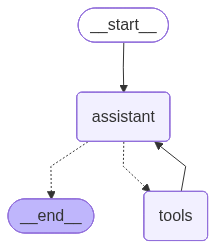

In [42]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
graph = builder.compile()
graph

In [ ]:
messages = [
    HumanMessage(
        content="график lineplot заболеваний по месяцам в 2023 году в спб среди мужчин и женщин"
    )
]
messages = graph.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

график заболеваний по месяцам в 2023 году в спб среди мужчин и женщин
================================== Ai Message ==================================

Для решения задачи мне нужно создать график заболеваний по месяцам в 2023 году в Санкт-Петербурге среди мужчин и женщин. 

Шаги:
1. Объединить таблицы пациентов и рецептов для получения информации о заболеваниях
2. Фильтровать данные по региону (Санкт-Петербург) и году (2023)
3. Сгруппировать данные по месяцам и полу
4. Подсчитать количество заболеваний для каждого месяца и пола
5. Создать график для визуализации данных

Сначала я выполню SQL-запрос для получения необходимых данных:
Tool Calls:
  execute_sql_tool (call_e5811716021647dcacf35d94)
 Call ID: call_e5811716021647dcacf35d94
  Args:
    query: SELECT 
    EXTRACT(MONTH FROM r.дата_рецепта) AS месяц,
    p.пол,
    COUNT(*) AS количество_заболеваний
FROM recipes r
JOIN patients p ON r.id_пациента =